# TP Optimisation II:  A simple neural network 

### (Rendu: en format ipynb et en html)

### Nom(s): DKHISSI
### Prénom(s): Mahmoud
### Groupe: B1

## Useful packages

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [3]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad { s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [4]:
#
# Nonlinear activation function
#

def softmax(x, alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    value = np.exp(x + alpha) / np.sum(np.exp(x + alpha))
    
    return value

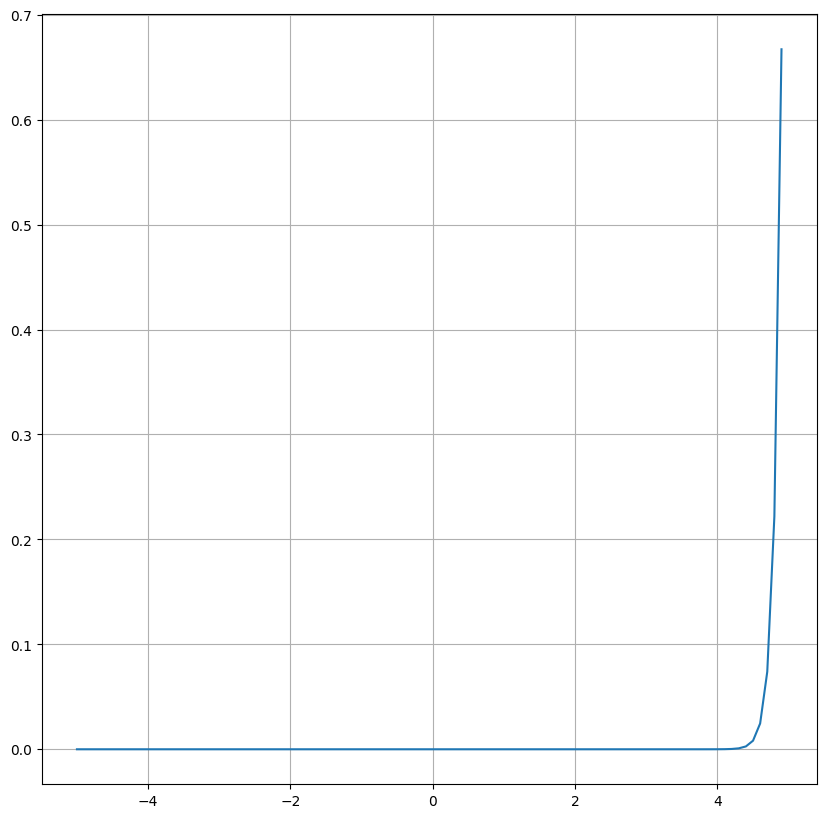

In [5]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [6]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    z = np.dot(W, x)
    n = np.size(W[:,0])
    alpha = np.zeros((n, 1))
    return softmax(z,alpha)


## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$

In [8]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    #
    # TO DO: return ce (cross_entropy)
    #
    ce = -np.sum(np.dot(np.transpose(target),np.log(pred)))
    #
    # gradient of the cross-entropy
    s = pred
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    pred = NN(x,W) 
    ce,grad = cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [10]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

1.8160660530952555
[[1.81606548]]


## Generating batches 

In [11]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [14]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)

        for batch in Batches:
            # Loop on the batches
            Sum_Grad = 0
            Ce_Train = 0
            train_accuracy = 0
            for i in batch:
                x_train = Xtrain[i]
                target = targets_train[i]
                ce,grad,pred = f(w,x_train,target)
                Sum_Grad += grad
                Ce_Train += ce
                if (list(pred).index(np.max(pred)) == list(target).index(1)):
                    train_accuracy += 1
                
            history[bs]['train acc'] += [train_accuracy/batch.shape[0]]
            history[bs]['train loss'] += [Ce_Train/batch.shape[0]]

            Sum_Grad = Sum_Grad.reshape(w.shape[0],w.shape[1])
            w = w - eta*Sum_Grad
                   
        # Test accuracy at the end of each epoch
        test_accuracy = 0
        ce_t = 0
        for i in range (len(Xtest)):
            target_test_i = targets_test[i]
            ce,grad,pred = f(w,Xtest[i],target_test_i)
            ce_t += ce
            if (list(pred).index(np.max(pred)) == list(target_test_i).index(1)):
                test_accuracy += 1
        history[bs]['test acc'] += [test_accuracy/Xtest.shape[0]]
        history[bs]['test loss'] += [ce_t/Xtest.shape[0]]
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        
    print('\n')            

batch size= 10000
Epoch number : 1 test accuracy: 0.1834 test loss 3.0035987888342723
Epoch number : 2 test accuracy: 0.2524 test loss 2.3825989006719763
Epoch number : 3 test accuracy: 0.3484 test loss 2.0107597692862704
Epoch number : 4 test accuracy: 0.4361 test loss 1.7520208084613136
Epoch number : 5 test accuracy: 0.4966 test loss 1.5640369515903667
Epoch number : 6 test accuracy: 0.5434 test loss 1.4219898164444909
Epoch number : 7 test accuracy: 0.5786 test loss 1.3111967095687682
Epoch number : 8 test accuracy: 0.6103 test loss 1.2220413084742072
Epoch number : 9 test accuracy: 0.6338 test loss 1.1485962966201015
Epoch number : 10 test accuracy: 0.6558 test loss 1.0871721596576476


batch size= 1024
Epoch number : 1 test accuracy: 0.1739 test loss 2.7834871103495717
Epoch number : 2 test accuracy: 0.2761 test loss 2.303801148096564
Epoch number : 3 test accuracy: 0.3704 test loss 1.9661578676061995
Epoch number : 4 test accuracy: 0.4442 test loss 1.7209530108261082
Epoch numbe

## Plots of the evolution of the loss function

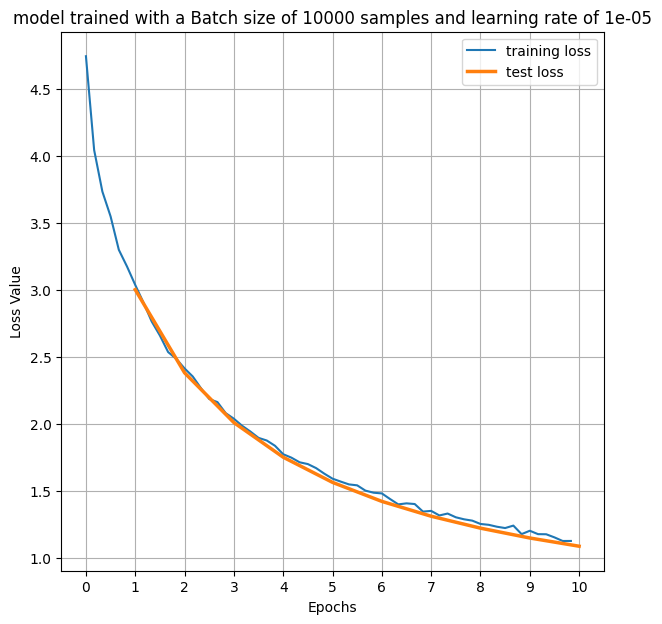

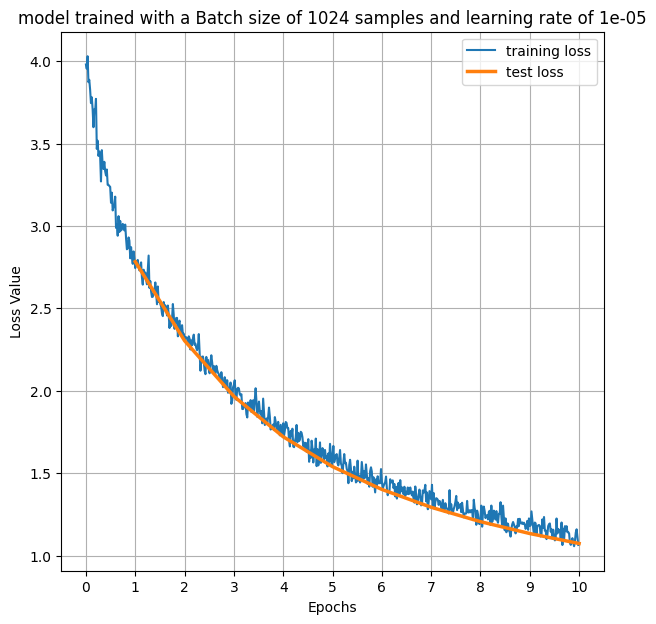

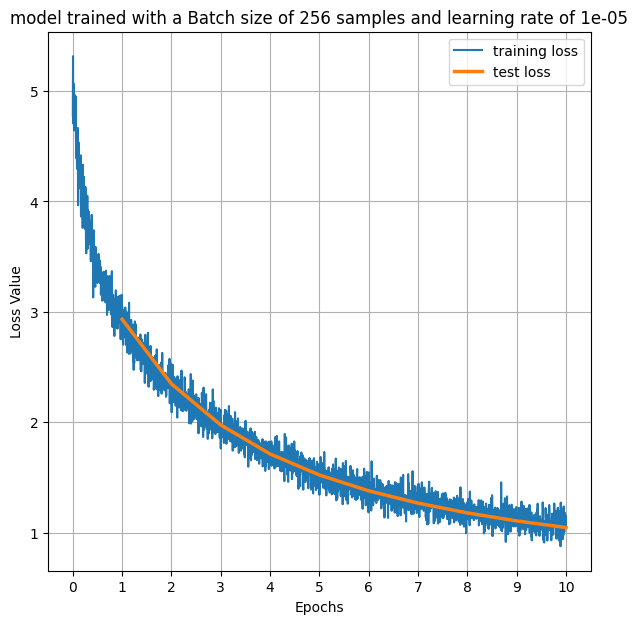

In [15]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000
6


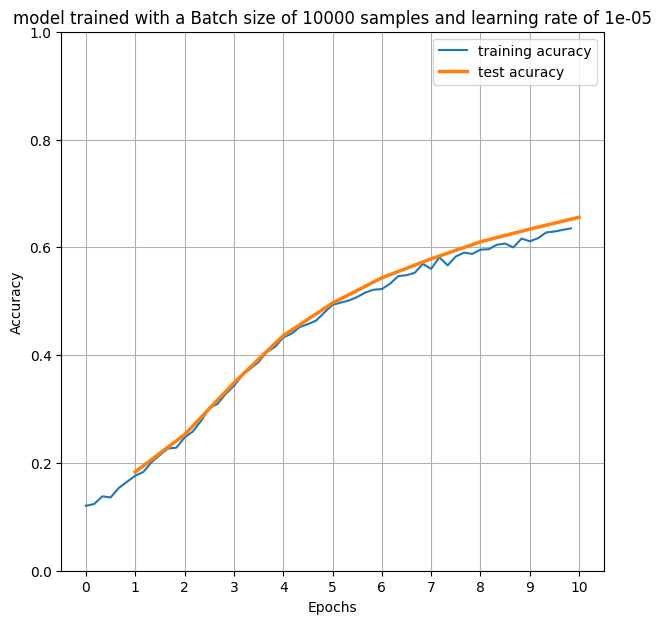

1024
59


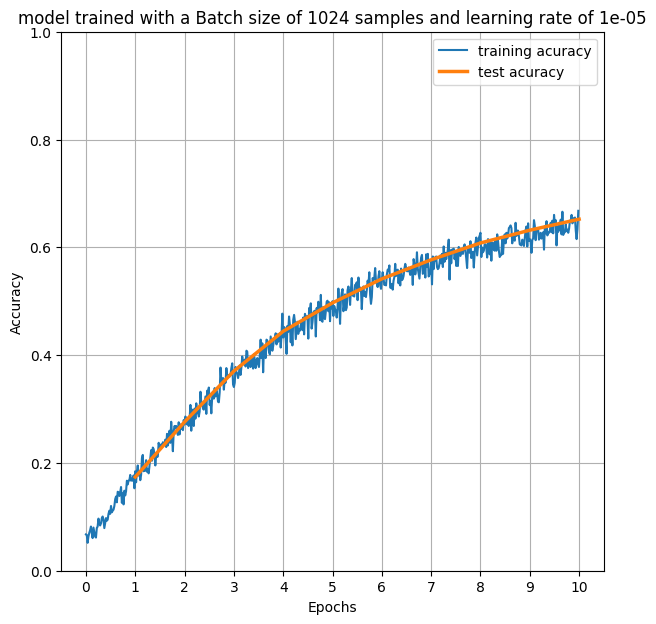

256
235


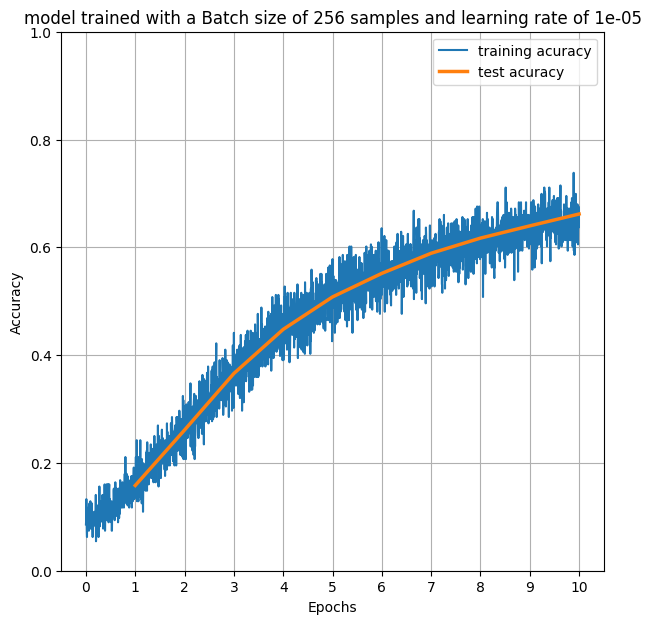

In [16]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments:

Tout d'abord, les résultats sont logiques, car nous observons une augmentation de la précision et une diminution de la perte.

#### Batch Size :


- Les tailles de lot plus petites peuvent introduire davantage de bruit dans le processus d'optimisation.
- Une taille de lot plus grande accélère le temps d'exécution par époque.
- Une taille de lot plus grande donne potentiellement une stabilité au processus d'apprentissage, et également la moyenne des gradients calculée sur un lot est plus précise, ce qui peut conduire à une convergence améliorée du modèle.
- Cependant, avec une taille de lot importante, le modèle pourrait converger vers un minimum local plutôt que global, et cela nécessiterait également une mémoire importante pour le stockage.


#### Learning rate :

- Un faible taux d'apprentissage entraîne une convergence lente vers le minimum.
- Un taux d'apprentissage plus élevé peut accélérer la convergence mais peut entraîner une instabilité ou une divergence.
- Il est donc important de rechercher un taux d'apprentissage optimal pour la tâche donnée.